# Изучение движения клиентов фитнес-клубов

<b>Цель:</b> провести исследование оттока клиентов сети фитнес-центов, провести анализ и подготовить план действий по удержанию клиентов.

<b>Задачи:</b>
1. Составить прогноз вероятности оттока каждого клиента на уровне следующего месяца.
2. Составить портреты клиентов, распределить клиентов по группам, составить характеристики групп.
3. Выявить основные признаки, наиболее сильно влияющие на отток клиентов. 
4. Разработать рекомендации по повышению качества работы с клиентами на основе целевых групп и особенностей взаимодействия с ними.

<b>Описание данных:</b><br>
Файл gym_churn.csv
- Данные клиента за предыдущий до проверки факта оттока месяц:
  - gender — пол;
  - Near_Location — проживание или работа в районе, где находится фитнес-центр;
  - Partner — сотрудник компании-партнёра клуба;
  - Promo_friends — использован промо-код по акции "приведи друга" для первичной записи;
  - Phone — контактный телефон;
  - Age — возраст;
  - Lifetime — количество месяцев с момента первого обращения в фитнес-центр.
- Информация о текущем статусе абонемента клиента:
  - Contract_period — длительность текущего действующего абонемента;
  - Month_to_end_contract — срок до окончания текущего действующего абонемента;
  - Group_visits — факт посещения групповых занятий;
  - Avg_class_frequency_total — средняя частота посещений в неделю за все время с начала действия абонемента;
  - Avg_class_frequency_current_month — средняя частота посещений в неделю за предыдущий месяц;
  - Avg_additional_charges_total — суммарная выручка от других услуг фитнес-центра;
- Churn — факт оттока в текущем месяце.

## Изучение данных и подготовка

In [1]:
#импортируем библиотеки

#обработка таблиц
import pandas as pd
pd.set_option('display.float_format', '{:,.2f}'.format)
pd.set_option('display.max_columns', None)

#рассчеты и работа с данными
import numpy as np

#графики и диаграммы
import matplotlib.pyplot as plt
import seaborn as sns

#алгоритмы машинного обучения
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram
import itertools

#вывод
import warnings
warnings.filterwarnings('ignore')

In [2]:
#загрузим датафрейм, укажем разделитель, проверим, что всё загрузилось
gym_churn = pd.read_csv('/datasets/gym_churn.csv')
gym_churn.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0


In [3]:
#Используем подготовленную в прошлых проектах функцию проверки основных данных
def check_df(data):
    
    #сводная информация о наборе данных
    data.info()
    
    #размер датасета
    print()
    print('Размер датасета:', data.shape)
        
    #проверка пропусков
    print()
    print(f"""Найдено пропусков:
{data.isna().sum()}""")
    
    #проверка дубликатов
    print()
    print('Найдено дубликатов:', data.duplicated().sum())

In [4]:
check_df(gym_churn)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

На первый взгляд пропусков нет. Типы столбцов корректны.<br>
Для удобства приведем заголовки столбцов к строчному регистру.

In [5]:
gym_churn.columns = gym_churn.columns.str.lower()

#проверим корректность преобразований
gym_churn.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

Проверим диапазоны значений в признаках.

In [6]:
#составим цикл, который выведет для каждого столбца список уникальных значений
for column in gym_churn.columns.to_list():
    print(f"""Имя столбца: {column}, 
Список уникальных значений: {gym_churn[column].unique()}
""")

Имя столбца: gender, 
Список уникальных значений: [1 0]

Имя столбца: near_location, 
Список уникальных значений: [1 0]

Имя столбца: partner, 
Список уникальных значений: [1 0]

Имя столбца: promo_friends, 
Список уникальных значений: [1 0]

Имя столбца: phone, 
Список уникальных значений: [0 1]

Имя столбца: contract_period, 
Список уникальных значений: [ 6 12  1]

Имя столбца: group_visits, 
Список уникальных значений: [1 0]

Имя столбца: age, 
Список уникальных значений: [29 31 28 33 26 34 32 30 23 27 35 25 36 24 21 37 22 19 20 38 39 18 41]

Имя столбца: avg_additional_charges_total, 
Список уникальных значений: [ 14.22747042 113.20293765 129.44847933 ...  78.25054157  61.91265691
 178.86181361]

Имя столбца: month_to_end_contract, 
Список уникальных значений: [ 5. 12.  1.  6.  3. 10. 11.  9.  4.  7.  8.  2.]

Имя столбца: lifetime, 
Список уникальных значений: [ 3  7  2  0  1 11  4  8 14  6  5 15 12 21 10 20  9 13 17 16 24 22 31 26
 23 18 19 27 29]

Имя столбца: avg_class_frequenc

### Вывод
В результате предварительной обработки данных установлено:
- датасет содержит 4000 наблюдений и 14 признаков;
- все признаки в датасете числовые;
- пропусков и дубликатов нет;
- заголовки столбцов приведены к строчному регистру;
- в столбцах с признаками, отражающими факт "да/нет", действительно присуствует только два значения.

## Исследовательский анализ данных (EDA)

### Описание признаков
Изучим средние значения и стандартные отклонения при помощи describe().

In [7]:
#транспонируем таблицу для удобства изучения признаков при помощи функции .Т
gym_churn.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,"4,000.00",0.51,0.50,0.00,0.00,1.00,1.00,1.00
near_location,"4,000.00",0.85,0.36,0.00,1.00,1.00,1.00,1.00
partner,"4,000.00",0.49,0.50,0.00,0.00,0.00,1.00,1.00
promo_friends,"4,000.00",0.31,0.46,0.00,0.00,0.00,1.00,1.00
phone,"4,000.00",0.90,0.30,0.00,1.00,1.00,1.00,1.00
contract_period,"4,000.00",4.68,4.55,1.00,1.00,1.00,6.00,12.00
group_visits,"4,000.00",0.41,0.49,0.00,0.00,0.00,1.00,1.00
age,"4,000.00",29.18,3.26,18.00,27.00,29.00,31.00,41.00
avg_additional_charges_total,"4,000.00",146.94,96.36,0.15,68.87,136.22,210.95,552.59
month_to_end_contract,"4,000.00",4.32,4.19,1.00,1.00,1.00,6.00,12.00


#### Вывод
Охрактеризуем данные клиентов за предыдущий до проверки факта оттока месяц:<br>
- <b>Признак "Пол"</b>: будем исходить из того, что 0 - это женщины, а 1 - сужчины; соотношение мужчин и женщин, посещающих фитнес-центр практически равное (51% мужчин и 49% женщин).
- <b>Признак "Проживание в районе фитнес-центра"</b>: большая часть клиентов (85%) живет(работает) в районе, где расположен фитнес-центр.
- <b>Признак "Сотрудник компании-партнёра клуба"</b>: почти половина клиентов (49%) получают скидки на абонемент как сотрудники компании-партнёра фитнес-центра (в сочетании с предыдущим признаком, можно говорить о том, что фитнес-центр расположен в деловом районе города).
- <b>Признак "Акция "Приведи друга""</b>: треть клиентов (31%) воспользовались промокодом от знакомого для оплаты первого абонемента (с позиции маркетинга, акцию по привлечению можно признать удачной).
- <b>Признак "Телефон"</b>: 90% клиентов оставили свой контактный номер телефона.
- <b>Признак "Возраст"</b>: возраст клиентов составляет от 18 до 41 года, в среднем 29 лет (с учетом признаков о работе клиентов - аудитория фитнес-центра наполовину состоит из молодого работающего населения). 
- <b>Признак "Лайфтайм"</b>: в среднем, с момента обращения в фитнес-центр до текущего среза данных прошло почти 4 месяца (медианное значение "жизни клиента" - всего 3 месяца), при этом максимальная длительность - больше 2,5 лет. Требуется уточнить дату открытия фитнес-центра (вопрос: являются ли эти посетители "старожилами" или же больше 2,5 лет клиенты не задерживаются?).


Охарактеризуем информация на основе журнала посещений, покупок и информацию о текущем статусе абонемента клиента:<br>
- <b>Признак "Текущий абонемент"</b>: средняя длительность абонемента составляет 4,7 месяцев, то есть превалируют клиенты покупающие абонемент на пробный период (месяц) или полгода, менее востребованы абонементы на год.
- <b>Признак "Скрок окончания абонемента"</b>: в среднем до окончания срока действия абонемента остается 4,32 месяца, а большей половины - (что еще больше характеризует гипотезу о невостребованности годовых абонементов).
- <b>Признак "Групповые занятия"</b>: 41% клиентов посетили хотя бы одно групповое занятие, это достаточно востребованная услуга.
- <b>Признак "Средняя частота посещений в неделю с начала действия абонемента"</b>: в среднем клиенты посещают около 2 занятий в неделю (1,88), однако, есть клиенты посещающие занятия каждый день с одним выходным днем (6 раз в неделю).
- <b>Признак "Средняя частота посещений в неделю за месяц"</b>: за месяц частота посещений ниже по сравнению с предыдущим показателем - 1,77, так же чуть выше максимальное число посещений - 6,15.
- <b>Признак "Выручка от прочих услуг"</b>: в среднем, клиенты тратят дополнительно около 146 у.е., в сравнении с максимальным значением в 552 у.е. Выручка от прочих услуг представляется не очень большой.


В текущем месяце <b>доля клиентов, переставших посещать занятия, составляет около 27% </b> - почти треть от аудитории фитнес-центра.


Что касается разброса значений: наблюдаются такие величины стандартных отклонений по разным признакам, которые требуют приведения к стандартному виду: проведения процессов нормализации и стандартизации данных перед обучением модели.  


### Разбивка данных на группы: отток и оставшие клиенты

Изучим средние значения признаков в двух группах — тех, кто ушел в отток (значение в столбце churn = 1) и тех, кто остался (значение в столбце churn = 0).

In [8]:
print(f"""В группе лояльных клиентов (churn=0) {gym_churn[gym_churn['churn'] == 0]['churn'].count()} человек.
В группе оттока (churn=1) {gym_churn[gym_churn['churn'] == 1]['churn'].count()} человек.""")

В группе лояльных клиентов (churn=0) 2939 человек.
В группе оттока (churn=1) 1061 человек.


In [9]:
#сгруппируем средние данные в две группы и также транспонируем таблицу для удобства
gym_churn.groupby('churn').agg('mean').T 

churn,0,1
gender,0.51,0.51
near_location,0.87,0.77
partner,0.53,0.36
promo_friends,0.35,0.18
phone,0.90,0.90
contract_period,5.75,1.73
group_visits,0.46,0.27
age,29.98,26.99
avg_additional_charges_total,158.45,115.08
month_to_end_contract,5.28,1.66


#### Выводы
- гендерное распределение для обеих групп идентично;
- клиенты, живущие/работающие рядом с фитнес-центром реже уходят;
- более лояльны к фитнес-центру клиенты, являющиеся сотрудниками компаний-партнеров;
- в два раза реже уходят клиенты, купившие первый абонемент по промоакции;
- почти все клиенты в каждой группе оставляют номер телефона;
- средняя длительность действующего абонемента у лояльных клиентов составляет почти полгода, чаще уходят клиенты, покупающие пробный абонемент на 1 месяц;
- групповые занятия посещают почти в два раза больше лояльных клиентов, чем ушедших;
- средний возраст ушедших клиентов несколько моложе, чем у оставшихся (окло 27 лет у ушедших и около 30 у оставшихся);
- лояльные клиенты в средням тратят больше, выручка от клинетов в оттоке чуть меньше;
- срок окончания абонемента у оставшихся клиентов существенно больше (почти полгода), нежели у клиентов в группе оттока (чуть меньше 2 мес.);
- аналогичен признак с лайфтаймом: лояльные клиенты в среднем занимаются около 5 месяцев с момента первого посещения, для клиентов из группы оттока этот показатель в среднем меньше 1 месяца;
- количество посещений в неделю за все время и за последний месяц у лояльных клиентов в два раза больше (клиенты из группы оттока ходят всего 1 раз в неделю).

Посмотрим более подробно на признаки, характеризующие время жизни клиентов в обеих группах - какие абонементы более востребованы и сколько при этом клиент задерживается в фитнес-центре.

In [10]:
#Длительность абонемента
(
    gym_churn.pivot_table(
        index='contract_period', 
        columns='churn', 
        values='gender', 
        aggfunc='count',
    )
   .style.background_gradient('Blues')
)

churn,0,1
contract_period,,
1,1273,934
6,729,104
12,937,23


В обоих случаях превалируют контракты на месяц. В группе оттока почти нет клиентов, купивших абонемент на полгода и более. А в группе лояльных клиентов существенное количество годичных абонементов.

Посмотрим на значения лайфтайма в обеих группах.

In [11]:
#Время с момента первого обращения в фитнес-центр (ограничимся годом)
(
    gym_churn.pivot_table(
        index='lifetime', 
        columns='churn', 
        values='gender', 
        aggfunc='count',
    )
   .head(13)
   .style.background_gradient('Blues')
   
)

churn,0,1
lifetime,,
0,84.000000,403.000000
1,429.000000,414.000000
2,453.000000,157.000000
3,440.000000,50.000000
4,360.000000,23.000000
5,265.000000,8.000000
6,216.000000,4.000000
7,167.000000,nan
8,110.000000,1.000000


Предварительно можно сказать, что имеется какая-то проблема с удержанием новых клиентов: они не только покупают абонементы на месяц, но и 38% из них бросают занятия ещё до окончания первого месяца, а ещё 40%.
Посетили ли клиенты из группы оттока, не продержавшиеся месяца, хотя бы одно занятие?

In [12]:
#всего клиентов из группы оттока не посетивших ни одного занятия за месяц
gym_churn.query('churn == 1 and lifetime == 0 and avg_class_frequency_current_month == 0')['gender'].count()        

53

In [13]:
#всего клиентов из группы оттока не посетивших вообще ни одного занятия
gym_churn.query('churn == 1 and lifetime == 0 and avg_class_frequency_total == 0')['gender'].count()

9

Не пришедших вообще не очень много

In [14]:
#всего клиентов из группы оттока не посетивших ни одного занятия за месяц
gym_churn.query('churn == 1 and lifetime == 0 and avg_class_frequency_current_month <= 1')['gender'].count()        

202

In [15]:
#всего клиентов из группы оттока не посетивших вообще ни одного занятия
gym_churn.query('churn == 1 and lifetime == 0 and avg_class_frequency_total <= 1')['gender'].count()

111

Число посетивших в среднем всего одного занятие в неделю за месяц и в целом уже существенно больше.

<b>Было бы полезно изучить поведение таких пользователей отдельно.</b> Но у нас имеются только средние данные.

### Распределение числовых признаков

Построим диаграммы по признакам для обеих групп.<br>
При построении учтём, что у нас есть два типа признаков:
- для фактологических (бинарных) признаков построим обычные гистограммы с частотой встречаемости;
- для численных (количественных) признаков построим гистограммы с отображением плотности распределения.

Для отображения на одном графике разделения по группам используем параметр hue библиотеки seaborn

#### Подготовка функции для отрисовки

In [16]:
#составим функцию
def draw_plots(data_to_plot): 
    
    #переименовываем столбцы для отрисовки
    data_to_plot = data_to_plot.rename(columns={
        'gender' : 'Пол',
        'near_location' : 'Проживание в районе фитнес-центра',
        'partner' : 'Сотрудник компании-партнера',
        'promo_friends' : 'Акция "Приведи друга"',
        'phone' : 'Телефон',
        'contract_period' : 'Текущий абонемент',
        'group_visits' : 'Групповые занятия',
        'age' :  'Возраст',
        'avg_additional_charges_total' : 'Выручка от прочих услуг',
        'month_to_end_contract' : 'Срок окончания абонемента',
        'lifetime' : 'Лайфтайм',
        'avg_class_frequency_total' : 'Средняя частота посещений в неделю с начала действия абонемента',
        'avg_class_frequency_current_month' :  'Средняя частота посещений в неделю за месяц',
        'churn' : 'Группа оттока'                
            })

    #получаем список столбцов
    columns_to_plot=data_to_plot.columns.to_list()
    
    #составяем список бинарных признаков
    fact_columns = ['Пол', 
                    'Проживание в районе фитнес-центра', 
                    'Сотрудник компании-партнера', 
                    'Акция "Приведи друга"', 
                    'Телефон',
                    'Групповые занятия',
                    'Группа оттока'
                   ] 
        
    #напишем цикл, который для каждого столбца в списке столбцов
    #будет проверять наличие столбца в списке бинарных признаков
    #в зависимости от результата сравнения будет выводить соотвествующую диаграмму
    for column in columns_to_plot:
        if column in fact_columns:
            plt.figure(figsize = (7, 5))
            sns.countplot(
                data=data_to_plot, 
                x=data_to_plot[column], 
                hue='Группа оттока'
            )
            plt.title('Признак "{}"'.format(column), fontsize=16)
            plt.ylabel('Количество клиентов', fontsize=14)
            plt.xlabel(column, fontsize=14)    
            plt.legend(['Группа лояльных клиентов', 'Группа оттока'], loc ='upper right')
            plt.show()
        else:
            sns.displot(
                x=data_to_plot[column], 
                hue='Группа оттока',
                multiple='dodge',
                kde=True,
                data=data_to_plot,
                height=5,
                aspect=2,
                legend=False
            )
            plt.title('Признак "{}"'.format(column), fontsize=16)
            plt.ylabel('Распределение', fontsize=14)
            plt.xlabel(column, fontsize=14)    
            plt.legend(['Группа оттока', 'Группа лояльных клиентов'], loc ='upper right')
            plt.show()            

#### Отрисовка диаграмм

Применим функцию к датафрейму и построим диаграммы.

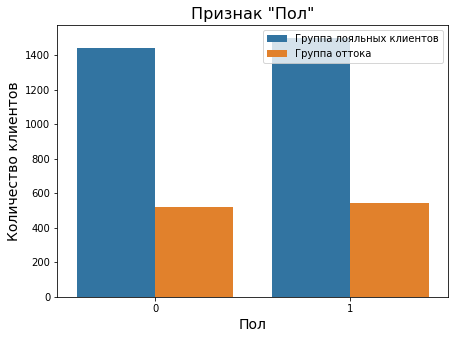

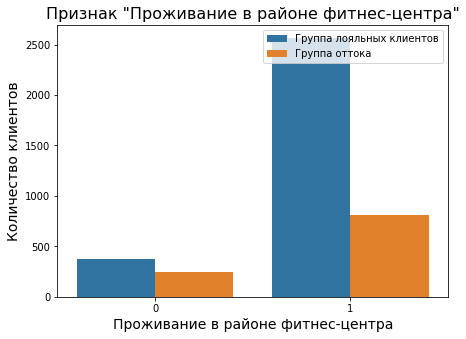

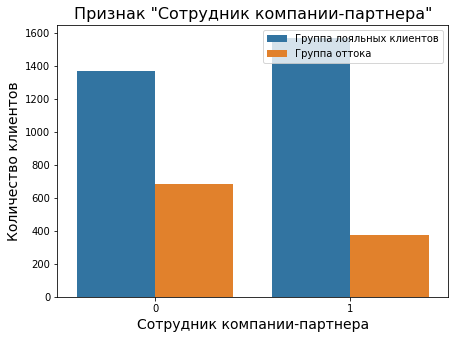

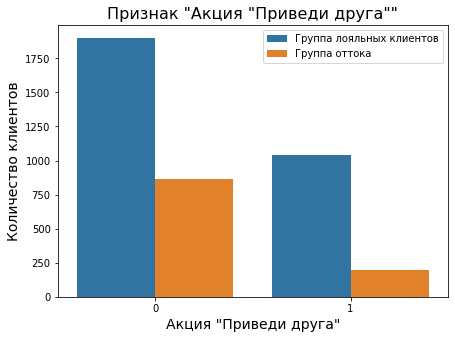

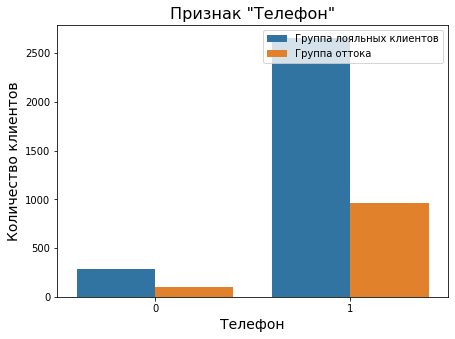

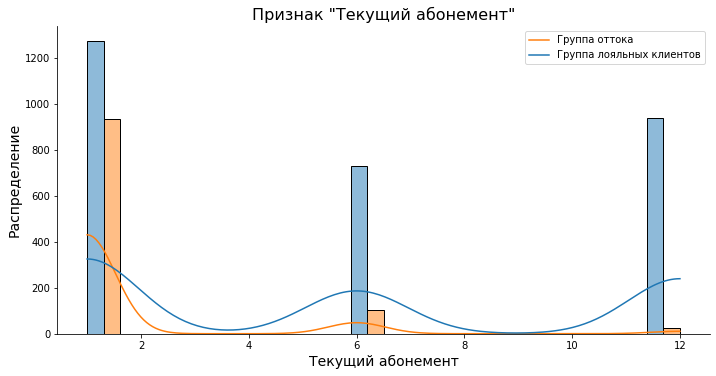

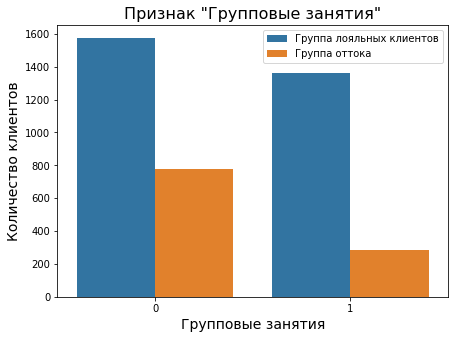

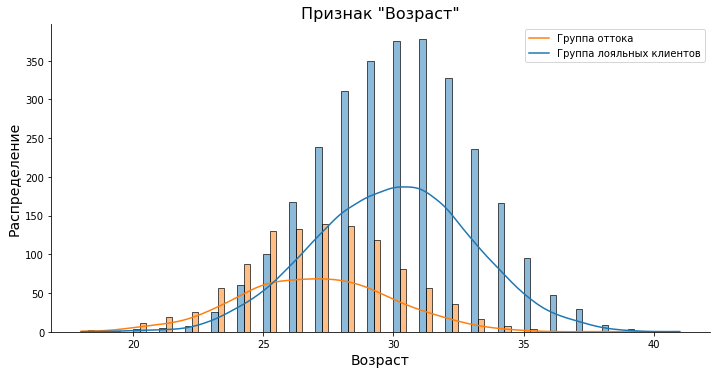

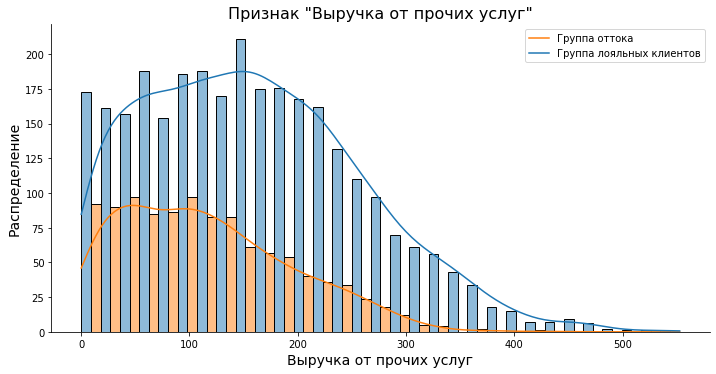

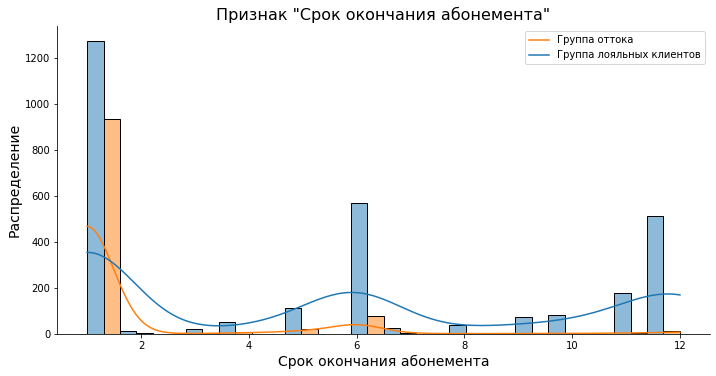

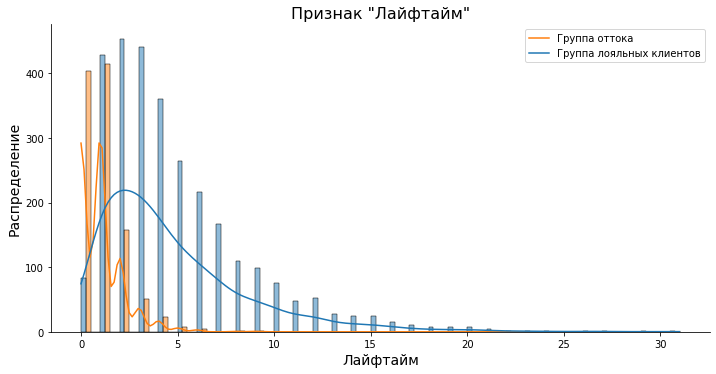

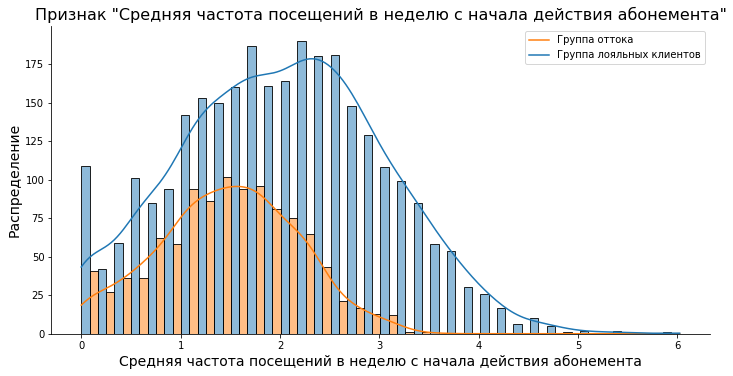

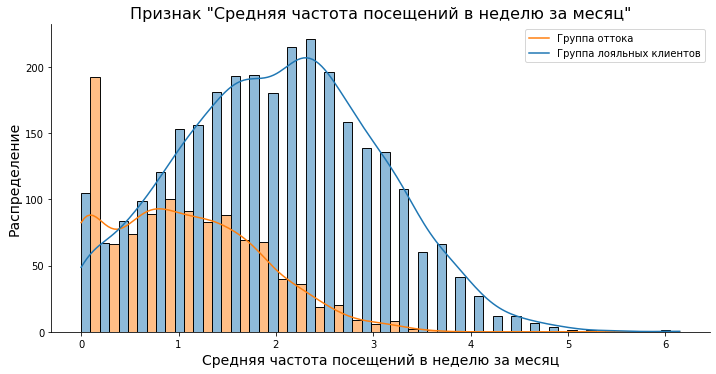

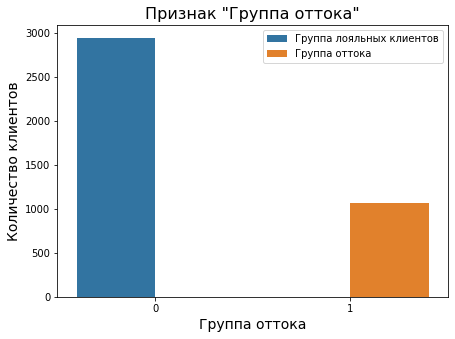

In [17]:
draw_plots(gym_churn)

#### Выводы

##### Бинарные признаки
- распределение количества по полу примерно похоже в обеих группах;
- гистограмма подтверждает, что наиболее лояльные клиенты - те, которые живут или работают рядом с фитнес-центром;
- примерно в два раза хуже удерживаются клиенты, не являющиеся сотрудниками компаний-партнеров (партенрская программа является упешной);
- промоакция на первую покупку абонемента успешно работает в обеих группах;
- практически все клиенты в обеих группах оставляют свой номер телефона;
- групповые занятия не являются мотивацией для группы оттока - их посещает менее половины таких клиентов;
- клиенты группы оттока составляют четверть всех наблюдейни в таблице;

##### Количественные признаки
- Длительность текущего абонемента у ллояльных клиентов примерно равномерно распределена между всеми тремя видами, у клиентов группы оттока преобладают абонементы на 1 месяц.
- Аудитория лояльных клиентов старше группы оттока примерно на 3 года (ушедшим клиентам - чаще около 26 лет, оставшимся - около 30).
- Средняя выручка от прочих услуг фитнес-центра в группе оттока достаточно высокая, несмотря на короткий срок их посещений. Возможно, для ушедших клиентов важную роль играет сопутствующая инфраструктура и товары, нежели сами занятия (на предыдущем графике мы видели низкую востребованность групповых занятий у таких клиентов).
- Срок до окончания текущего абонемента у группы оттока составляет, в основном, 1 месяц.
- Лайфтайм лояльных клиентов постепенно снижается после полугода, тогда как в группе оттока он резко обрывается после 1 месяца "жизни".
- Лояльные клиенты в среднем посещают фитнес-центр 2-3 раза в неделю, у ушедших преобладает 1-2 посещения.
- За последний месяц клиенты из группы оттока практически не посещали занятия, оставшиеся так же ходят 2-3 раза в неделю.

### Матрица корреляций

Вычислим корреляционную матрицу и её визуализируем

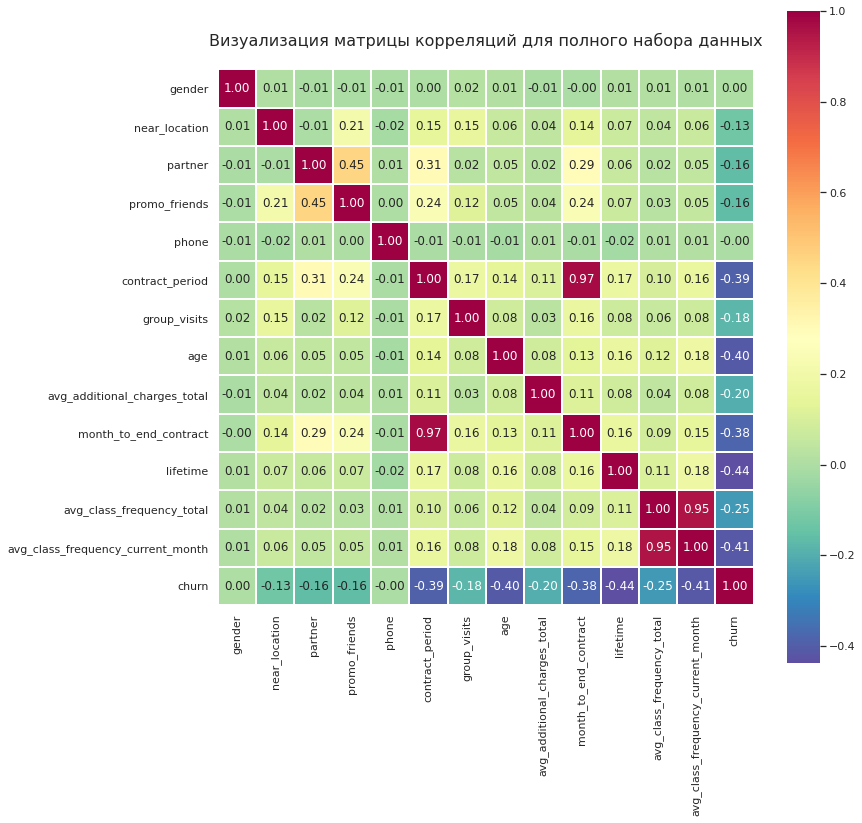

In [18]:
plt.figure(figsize=(12,12))
sns.set(style='white')
sns.heatmap(gym_churn.corr(), annot=True, square=True, fmt='0.2f', linewidths=1, cmap= 'Spectral_r')
plt.title('Визуализация матрицы корреляций для полного набора данных\n', fontsize=16)
plt.show()

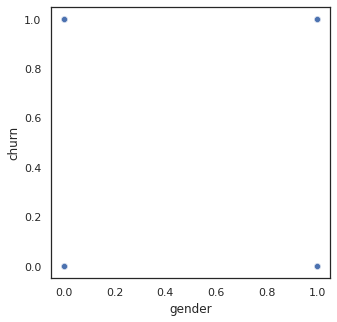

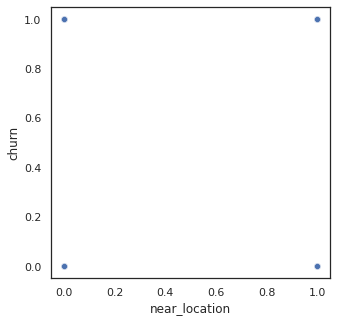

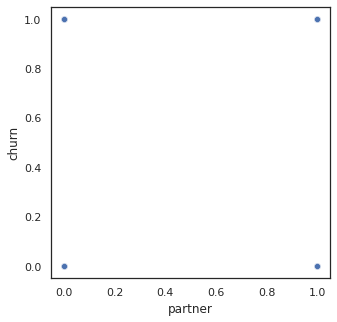

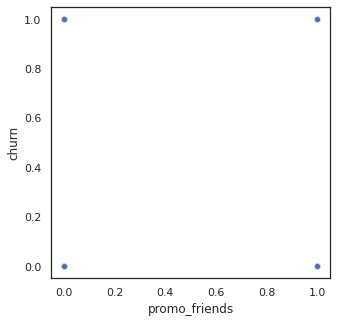

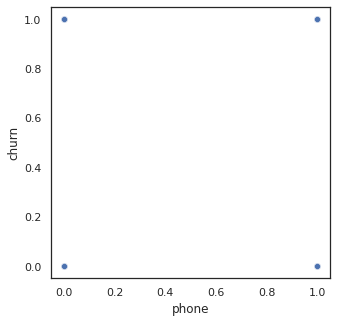

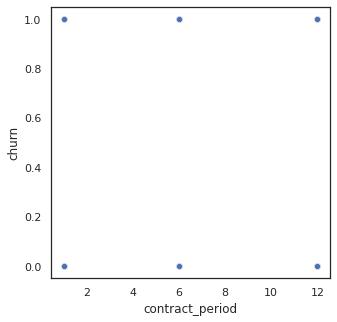

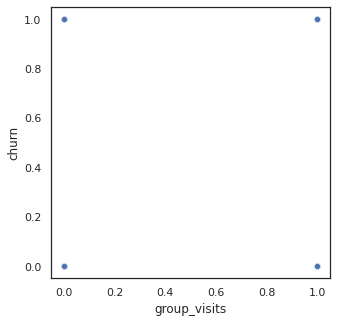

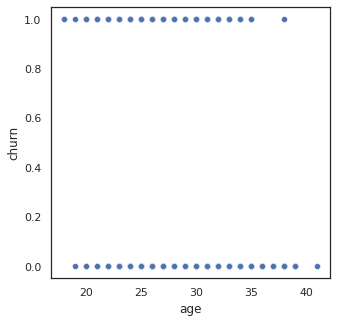

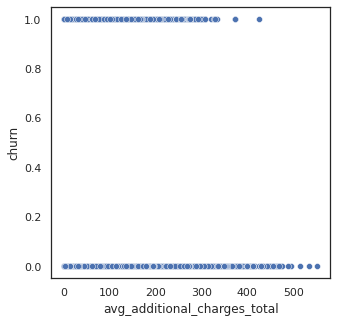

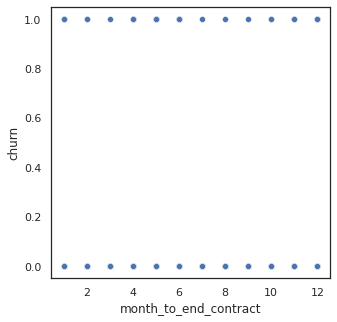

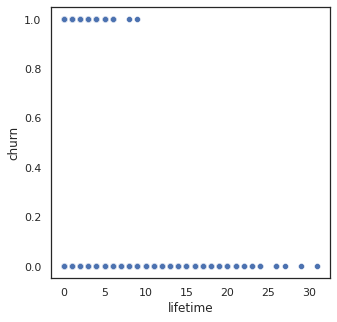

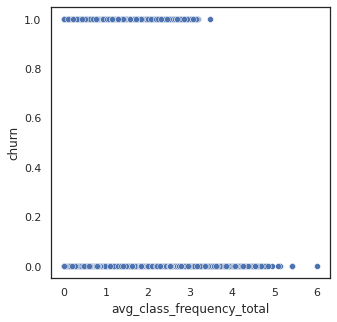

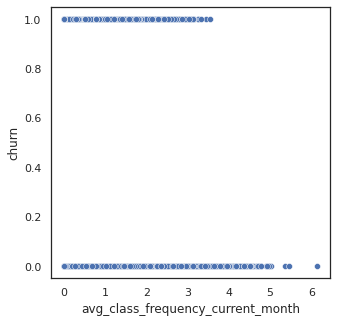

In [19]:
#построим попарные диаграммы рассеяния признак-целевая переменная для каждого признака
for col in gym_churn.drop('churn', axis = 1).columns:
    plt.figure(figsize = (5, 5))
    sns.scatterplot(gym_churn[col], gym_churn['churn'])
    plt.show()

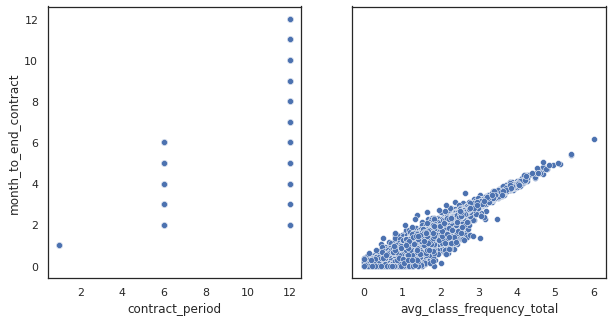

In [20]:
#построим попарные диаграммы рассеяния взаимозависимых признаков
fig, (ax_1, ax_2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 5))
sns.scatterplot(gym_churn['contract_period'], gym_churn['month_to_end_contract'], ax = ax_1)
sns.scatterplot(gym_churn['avg_class_frequency_total'], gym_churn['avg_class_frequency_current_month'], ax = ax_2)
plt.show()

#### Выводы

Проведен рассчет корреляции признаков с целевой переменной (факт оттока, churn равный 1).

- На отток клиентов практически не влияют такие признаки как пол, контактный телефон.
- Наблюдается сильная отрицательная корреляция между целевой переменной и следующими признаками: длительность текущего абонемента (-0,38), возраст (-0,40), срок до окончания текущего действующего абонемента (-0,38), лайфтайм (-0,44) и средняя частота посещений в неделю за предыдущий месяц (-0,41). Отрицательное значение корреляции говорит о том, что возрастание значений признака приведет к уменьшению количества клиентов в группе оттока.
- Выявлены взаимозависимости между такими признаками как: 
  - длительность текущего абонемента и срок до окончания текущего действующего абонемента (в отсуствие сведений о датах, предположим, что в выгрузку могли попасть клиенты только купившие абонемент);
  - средняя частота посещений в неделю за предыдущий месяц и средняя частота посещений в неделю за все время с начала действия абонемента (по графикам и предварительному анализу видно, что в любой группе число посещений в каждом из этих признаков составляет около 2 раз в неделю, как правило, клиенты придерживаются постоянного расписания и из месяца в месяц их активность не изменяется).
  
Каких-либо ярких выбросов и перекосов по диаграммам рассения признак-факт отттока не наблюдается. А диаграмма разброса между двумя средними по числу занятий (в месяца и с начала абонемента) показывает сильную взаимозависимость между двумя признаками.

In [21]:
gym_churn_clear=gym_churn.drop(['month_to_end_contract', 'avg_class_frequency_total'], axis = 1)
gym_churn_clear.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.23,3,0.00,0
1,0,1,0,0,1,12,1,31,113.20,7,1.91,0
2,0,1,1,0,1,1,0,28,129.45,2,1.74,0
3,0,1,1,1,1,12,1,33,62.67,2,3.36,0
4,1,1,1,1,1,1,0,26,198.36,3,1.12,0


### Вывод

В результате исследовательского анализа были изучены средние значения и стандартные отклонения <b>13 признаков, 1 целевая переменная в 4000 наблюдений</b> в целом и в разрезе групп по факту оттока. Получены следующие результаты:
- Соотношение мужчин и женщин практически одинаковое в целом и в разрезе групп в частности (51% к 49%).
- Большинство клиентов посещают фитнес-центр из-за близкого расположения с жильём/работой. Такие клиенты реже попадают в отток.
- Чуть меньше половины клиентов (47% от общего числа) являются сотрудниками компаний партнерской программы. Эти клиенты склонны проявлять большую лояльность и оставаться с фитннес-центром.
- Треть клиентов приобрели абонемент в рамках промо-акции "Приведи друга" (31%). Такие клиенты уходят реже.
- Практически все клиенты оставляют контактный телефон, на отток этот признак не влияет.
- Средняя длительность абонемента больше 1 месяца, но менее полугода (4,7 мес.). При этом больше половины клиентов пользуются абонементом на 1 месяц и не задерживаются в фитнес-центре. Среднеее "время жизни клиента" - 4 месяца, чаще всего у оставшихся этот признак составляет 2-3 месяца, у уходящих - месяц и менее. Встречаются и "долгожители" (от года и более).
- Групповые занятия достаточно востребованы (41% от общего числа клиентов их посещает). При этом клиенты, попавшие в группу оттока, такие занятия посещают намного реже по сравнению с оставшимися.
- Разбивка по возрасту показывает, что остающиеся клиенты чуть старше уходящих (30 лет и 26 лет соотвественно).
- Средняя выручка с прочих услуг не велика - 146 у.е. (при максимуме 552 у.е). Интересно отметить. что уходящие клиенты так же склонны оплачивать сопутствующие услуги и товары, не смотря на малое время посещения.
- В среднем, клиенты посещают 2 занятия в неделю (у оставшихся клиентов этот показатель приближается к 3, у клиентов оттока - к единице). В двух близких признаках (со времени действия абонемента и за прошедший месяц) практически нет разницы. Однако стоит отметить, что за прошедший месяц в группе оттока имеется достаточное количество людей, не посещавших фитнес-центр вообще или посетивших всего 1 занятие, несмотря на покупку абонемента.

Таким образом, наблюдается <b>проблема с привлечением и удержанием новых клиентов<b>.<br>
Отметим, что за прошедший месяц <b>27% клиентов попало в группу оттока</b>.

Для оценки влияния признаков на отток клиентов и установления взаимовлияния признаков друг на друга был проведен расчет построена <b>матрица корреляции</b> при помощи теловой карты.

Установлено:
- Все признаки имеют отрицательный знак корреляции. Следовательно, возрастание признака привведет к уменьшею оттока клиентов.
- Наименьшее влияние на отток оказывают такие признаки как пол и телефон.
- Наибольшую отрицательную корреляцию показывают:длительность текущего абонемента, возраст, срок до окончания текущего действующего абонемента, лайфтайм и средняя частота посещений в неделю за предыдущий месяц.
- Имеется сильная связь между признаками длительности текущего абонемента и количеством месяцев до его окончания, между средней частотой посещений с начала использования абонемента и за прошедший месяц. Из проанализированных данных видно, что средняя длительность абонементов не велика, абонементы на 1 месяц самые востребованные, а на диаграмме рассеяния видна сильная зависимость между двумя признаками. Таким данные могут создавать шум в процессе обучения модели.

## Модель прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце. Сохраним признаки и целевую величину в соответствующие переменные.

In [22]:
#разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = gym_churn_clear.drop('churn', axis=1)
y = gym_churn_clear['churn']

По диаграммам количественных признаков, построенных ранее, видно, что для корректного обучения модели необходимо провести стандартизацию признаков.

Используем классическое деление на обучающую и валидационную выборку в пропорции 80:20.

In [28]:
#разделяем модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

In [31]:
# создадим объект класса StandardScaler и применим его к матрице Х
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train) #fit на обучающей
X_test_st = scaler.transform(X_test) #transform на валидационной
X_sc = scaler.transform(X) #transform на всех далее для кластеризации

С учётом наиболее разбиения выборки на train/test, возможных вариантов алгоритмов и подходящих для данной задачи метрик, мы можем сравнить модели и выбрать лучшую.

<b>Тип задачи:</b> <br>
Обучение с учителем: бинарная классификация <br>
Пояснение: целевая переменная может принимать только два значения: 1 (имеется факт оттока), 0 (факт оттока отсуствует).

<b>Используемые алгоритмы: </b>
- логистическая регрессия (реализация через sklearn.linear_model.LogisticRegression()),
- случайный лес (реализация через sklearn.ensemble.RandomForestClassifier()).

<b>Метрики:</b>
- accuracy (доля правильных ответов алгоритма), зависит от соотношения классов, чем ближе значение accuracy к 100%, тем лучше;
- precision (точность) - доля объектов, названных классификатором положительными и при этом действительно являющимися положительными, это способность отличать этот класс от других классов;
- recall (полнота) - показывает, какую долю объектов положительного класса из всех объектов положительного класса нашел алгоритм, способность алгоритма обнаруживать конкретный класс.

Дополнительно рассчитаем метрику F1_score, так как precision и recall направлены на избежание противоположных рисков, и нужна сводная метрика, учитывающая баланс между метриками. Чем ближе F1 к единице - тем лучше. 


Создадим список алгоритмов и напишем функцию, которая будет обучать каждую модель на train-выборке, делать прогноз на тестовых данных и выводить метрики.

In [32]:
# зададим список моделей
models = [
    LogisticRegression(random_state = 0, solver='liblinear'),
    RandomForestClassifier(random_state = 0, n_estimators=100)
]

In [33]:
# функция, которая принимает на вход модель и данные и выводит метрики
def make_prediction(m, X_train, y_train, X_test, y_test):
    
    # зададим алгоритм для нашей модели
    model = m
    
    # обучим модель
    model.fit(X_train, y_train)
    
    # рассчитаем бинарный прогноз
    y_pred = model.predict(X_test)
    
    # выведем метрики
    print('Метрики при автоматическом прогнозе с помощью predict')
    print(
        'Accuracy: {:.2f} / Precision: {:.2f} / Recall: {:.2f} / F1: {:.2f} '.format(
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred),
            f1_score(y_test, y_pred),
        )
    )
   # воспользуемся уже обученной моделью, чтобы сделать прогнозы
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # зададим порог
    threshold = 0.4

    # на основании вероятностей и соотношения классов перерассчитаем predict
    custom_pred = [0 if i < threshold else 1 for i in y_prob]

    # выведем метрики для прогноза по новому порогу
    print('Метрики для прогноза с кастомным порогом')
    print(
        'Accuracy: {:.2f} / Precision: {:.2f} / Recall: {:.2f} / F1: {:.2f} '.format(
            accuracy_score(y_test, custom_pred),
            precision_score(y_test, custom_pred),
            recall_score(y_test, custom_pred),
            f1_score(y_test, custom_pred),
        )
    )
    print() 

In [34]:
# напишите цикл, который выводит метрики по списку моделей
for i in models:
    print(i)
    make_prediction(m=i, X_train=X_train, y_train=y_train,
                    X_test=X_test, y_test=y_test)

LogisticRegression(random_state=0, solver='liblinear')
Метрики при автоматическом прогнозе с помощью predict
Accuracy: 0.90 / Precision: 0.79 / Recall: 0.79 / F1: 0.79 
Метрики для прогноза с кастомным порогом
Accuracy: 0.89 / Precision: 0.75 / Recall: 0.86 / F1: 0.80 

RandomForestClassifier(random_state=0)
Метрики при автоматическом прогнозе с помощью predict
Accuracy: 0.90 / Precision: 0.81 / Recall: 0.75 / F1: 0.78 
Метрики для прогноза с кастомным порогом
Accuracy: 0.89 / Precision: 0.75 / Recall: 0.84 / F1: 0.79 



Рассчет метрик показывает, что оба алгоритма способны давать прогнозы достаточно хорошо. Однако, модель логистической регрессии показывает чуть лучшие результаты по точности (precision) и полноте (recall), что подтсверждается в рассчетах метрики F1_score.

Однако при изменении порога до 0,4 метрика полноты вырастает в обоих алгоритмах, а точность, наоборот, снижается. При этом на F1 изменение порога повлияло незначительно.

### Вывод
- Для формирования модели прогнозирования оттока клиентов была проведена оценка работы двух алгоритмов - логистической регрессии и ансамблевой модели случайного леса.
- Целевой переменной являлся факт оттока клиента в следующем месяцк.
- Каждая модель была обучена на обучающей выборке и проверена на валидационной. Соотношение выборок составило 80 к 20.
- Для каждого алгоритма был проведен рассчет по 4 метркиам: accuracy, precision, recall, F1_score.
- Модель линейной регрессии показала чуть более хорошие результаты по стандартной оценке метрик.
- Изменение порога изменяет и показатели производительности. Рекомендуется для более точной оценки и вырадения большей степени уверенности модели в окончательном бинарном ответе.

## Кластеризация клиентов

Стандартизация данных была проведена на предыдущем этапе. Опустим здесь этот шаг, будем использовать уже обработанные данные.

###  Матрицы расстояния и дендрограмма

Сохраним в переменной links матрицу расстояний и визуализируем расстояния между объектами и отрисуем на ее основе дендрограммую

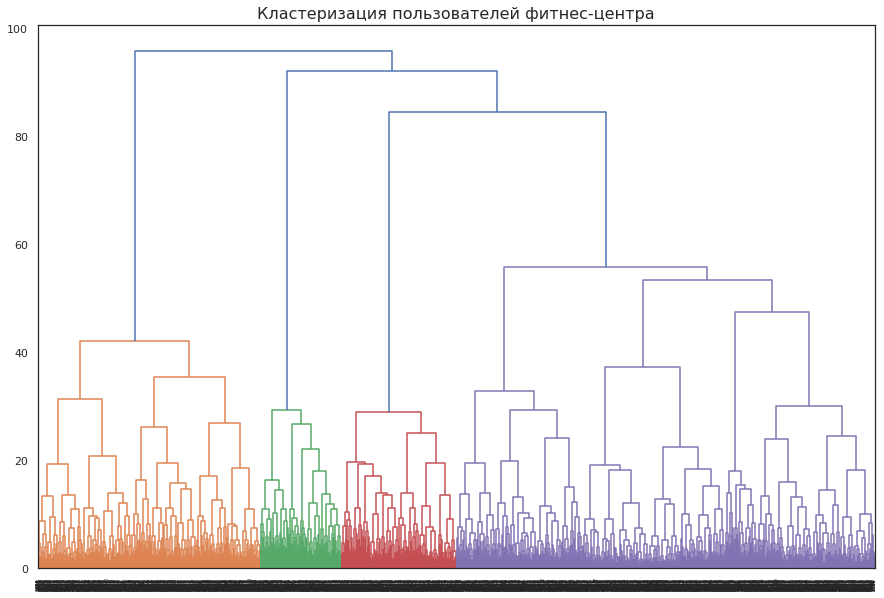

In [35]:
# сохранение матрицы расстояний в переменной links
links = linkage(X_sc, method = 'ward')

# построение дендрограммы методом dendrogram
plt.figure(figsize=(15, 10))
plt.title('Кластеризация пользователей фитнес-центра', fontsize=16)
dendrogram(links, orientation='top')
plt.show()

#### Вывод

Дендрограмма (dendrogram) - древовидная диаграмма, содержащая n уровней, каждый из которых соответствует одному из шагов процесса последовательного укрупнения кластеров.

На основании полученного графика, явно выделяются <b>четыре кластера</b> в данных. Причем, последний из них превышает остальные более чем в два раза.

### Алгоритм кластеризации K-means

Зададим модель на основании алгоритма K-means c числом кластеров n=5 и зафиксируем значение параметра random_state.

In [36]:
# задаём модель k_means
km = KMeans(n_clusters=5, random_state=0)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
labels = km.fit_predict(X_sc)

In [37]:
# сохраняем метки кластера в поле нашего датасета
gym_churn_clear['cluster'] = labels

In [38]:
# выводим статистику по средним значениям признаков по кластеру
gym_churn_clear.groupby('cluster').mean().T

cluster,0,1,2,3,4
gender,0.50,0.54,0.50,0.50,0.52
near_location,1.00,1.00,1.00,0.00,0.86
partner,0.90,0.40,0.20,0.49,0.47
promo_friends,1.00,0.01,0.07,0.08,0.31
phone,1.00,1.00,1.00,1.00,0.00
contract_period,6.91,6.55,1.98,2.99,4.78
group_visits,0.52,0.53,0.30,0.23,0.43
age,29.57,30.75,27.75,28.68,29.30
avg_additional_charges_total,152.81,176.47,123.01,137.13,144.21
lifetime,4.22,5.63,2.00,2.97,3.94


#### Вывод
Изучим средние значения признаков для кластеров:

<b>0</b> Клиенты, которые живут/работают в непосредственной близости от фитнес-центра. Среди них самая большая доля участников партнерских программ. Обладатели самых длительных абонементов. Активно покупают сопутствующие услуги. Все записались первоначально по промо-акции. Посещают фитнес-центр около 2 раз в неделю. Кластер с одним из наименьшим оттоком клиентов.

<b>1</b> Клиенты, которые не живут/работают в районе, где расположен фитнес-центр, не воспользовавшиеся записью по промоакции, почти не посещающие групповые занятия. В 50% случаев являются сотрудниками партнерских компаний. Среди них мало востребованы дополнительные услуги. Длительность абонемента составляет около 3 месяцев. Высокая тенденция оттока (40%).

<b>2</b> Клиенты, которые живут/работают в непосредственной близости от фитнес-центра. В 20% случаев сотрудники компаний-партнеров. Промоакция не востребована. Почти не посещают групповые занятия, дополнительные услуги покупают редко. Самая молодая аудитория - 27,5 лет. Длительность абонемента составляет 2 месяца. Самый большой процент оттока - 56%.

<b>3</b> Клиенты, которые живут/работают в непосредственной близости от фитнес-центра, не воспользовавшиеся записью по промоакции. Активно посещающие групповые занятия (54%). Среди них очень востребованы дополнительные услуги. Самый длительный лафйтайм. Самая возрастная группа (30 лет). Длительность абонемента составляет около полугода. Чаще всего посещают фитнес-центр (2 раза в неделю)Оттока практически нет (1%) - это самая лояльная категория клиентов.

<b>4</b> Клиенты, которые живут/работают примерно в районе от фитнес-центра. Не оставили свой контактный номер телефона. 47% из них являются сотрудниками компаний-партнеров, в 30% случаев использовали промоакцию при первичной записи. Средняя длительность абонемента - около 5 месяцев. Ходят на групповые занятия. Оплачивают дополнительные услуги. Процент оттока составляет 27%

### Распределение признаков для кластеров

In [39]:
# определим функцию отрисовки графиков попарных признаков для кластеров
def show_clusters_on_plot(df, x_name, y_name, cluster_name):
    plt.figure(figsize=(5, 5))
    sns.scatterplot(
        df[x_name], df[y_name], hue=df[cluster_name], palette='Paired'
    )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()

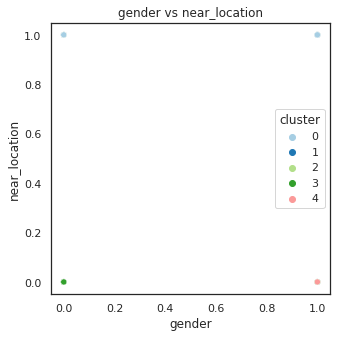

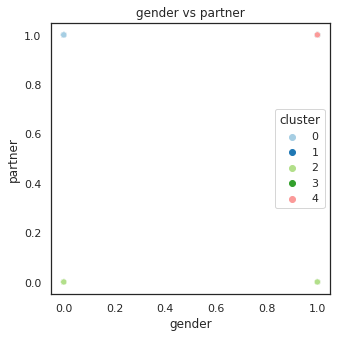

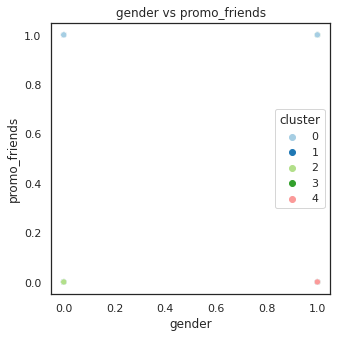

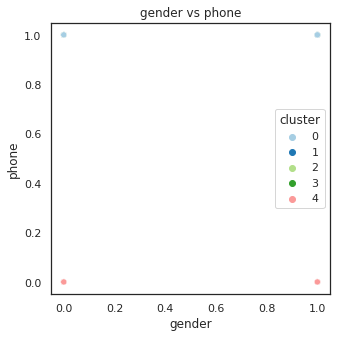

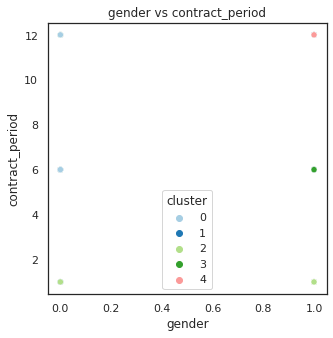

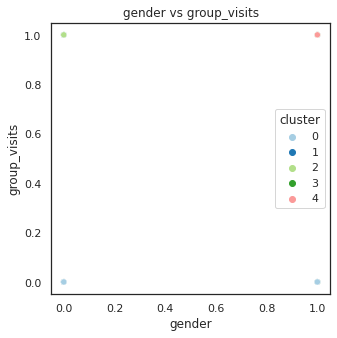

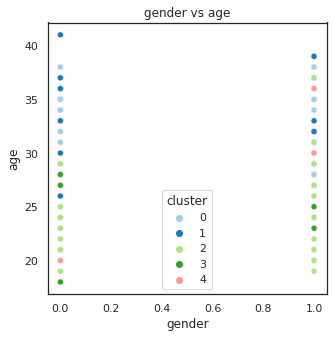

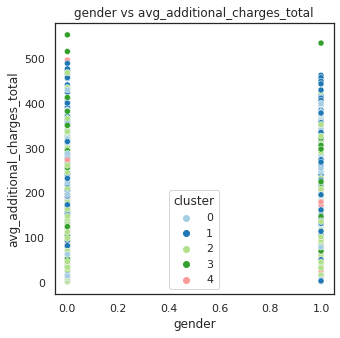

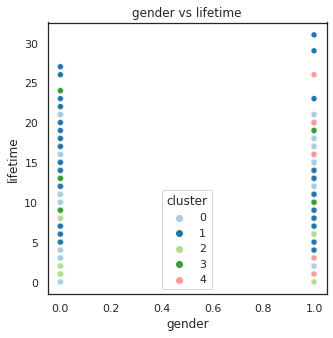

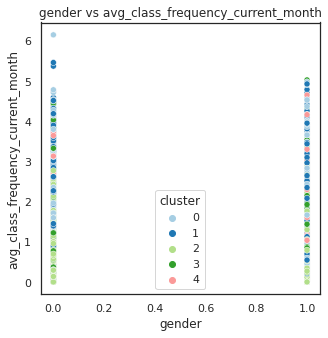

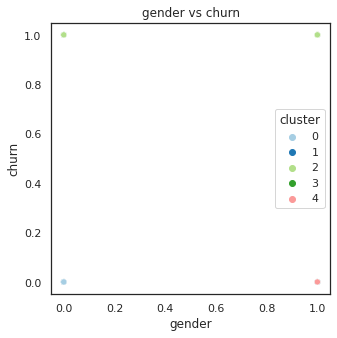

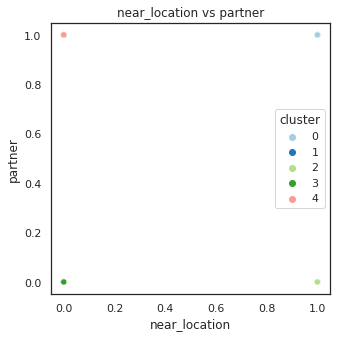

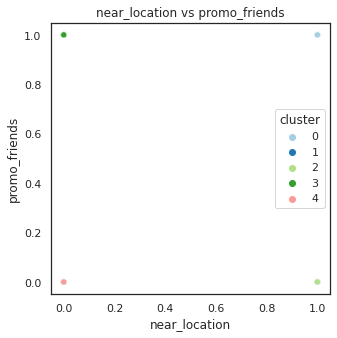

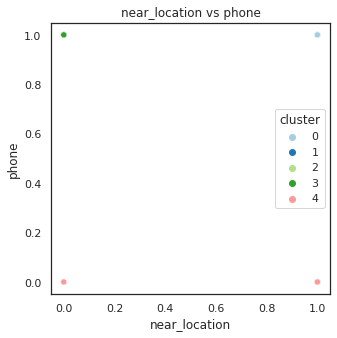

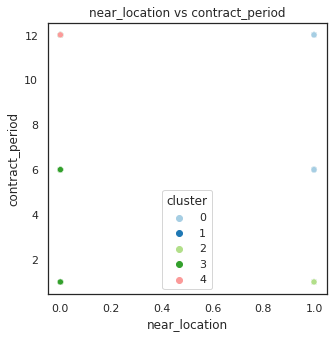

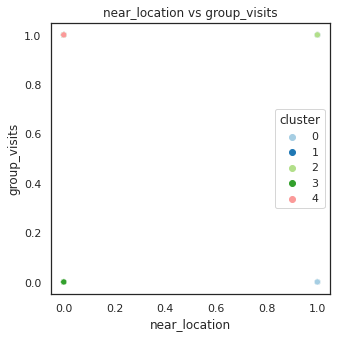

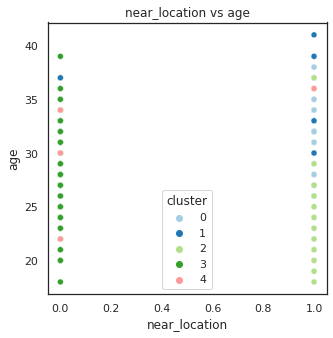

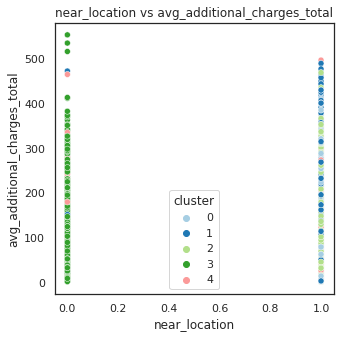

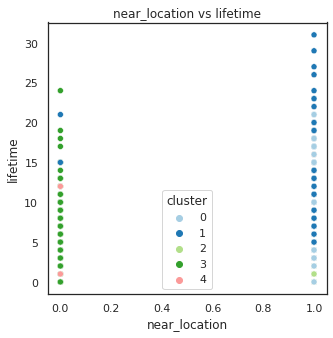

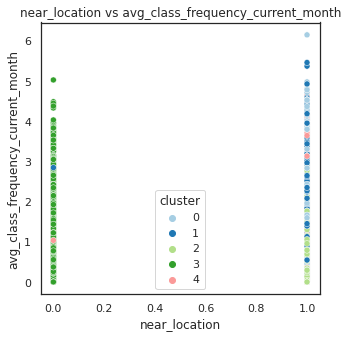

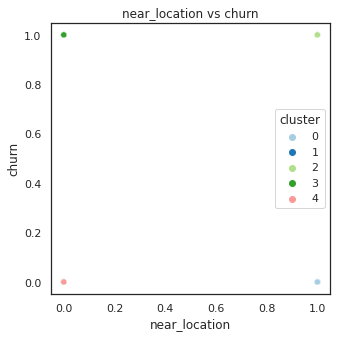

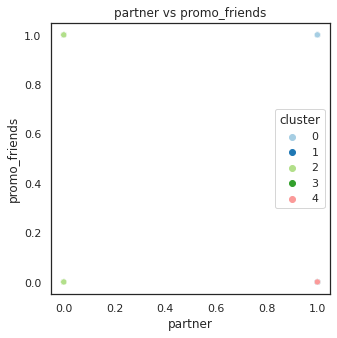

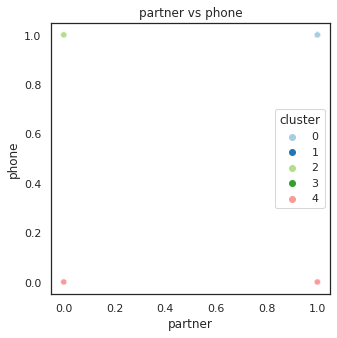

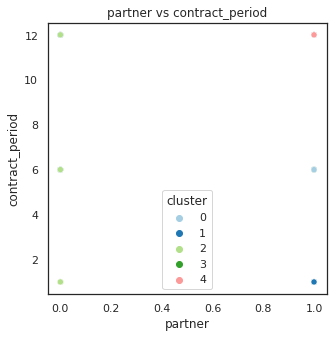

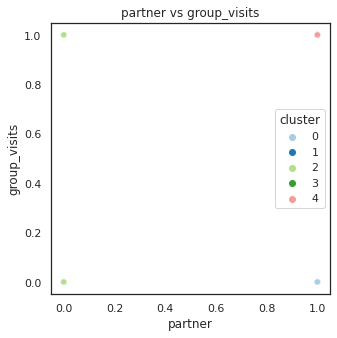

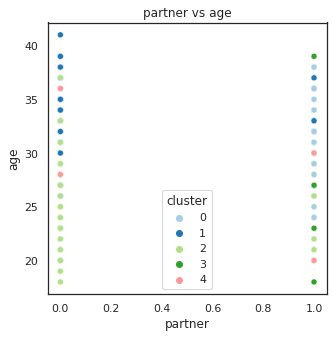

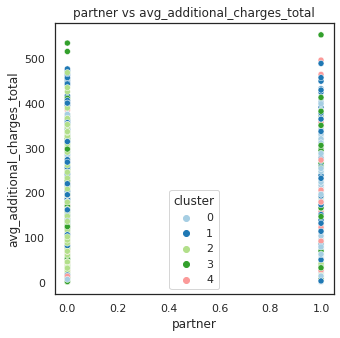

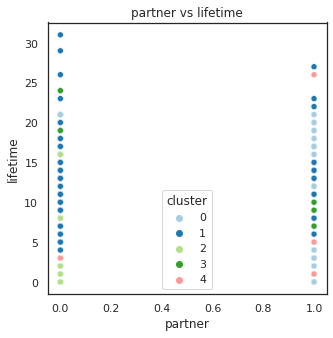

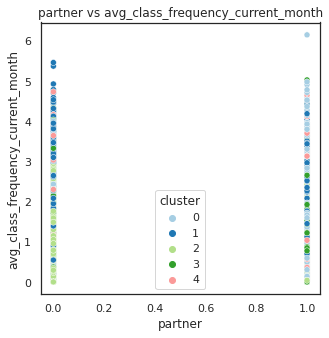

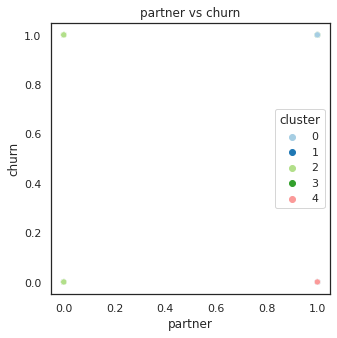

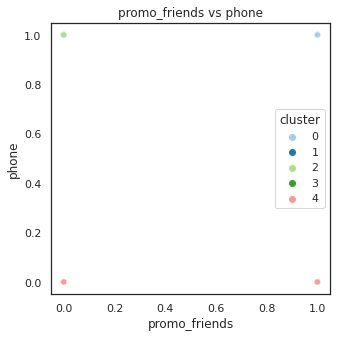

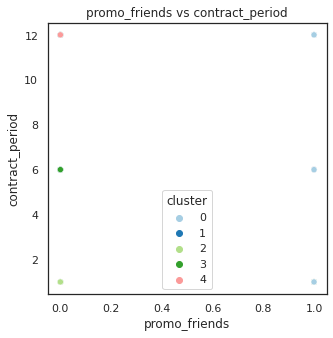

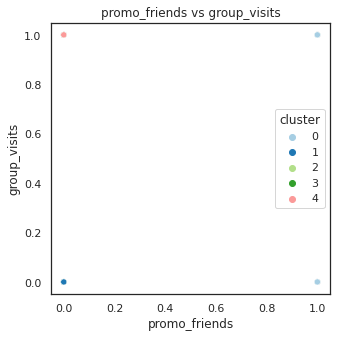

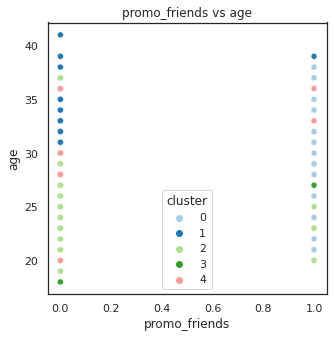

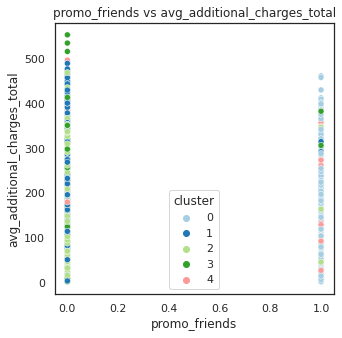

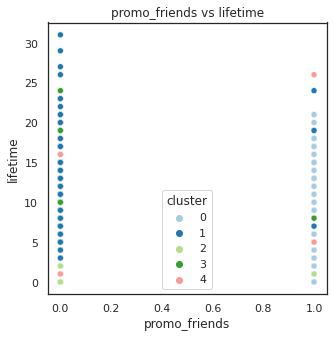

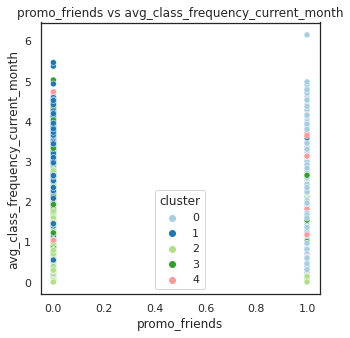

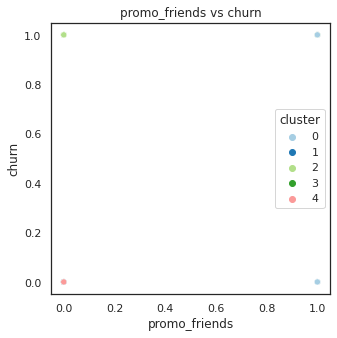

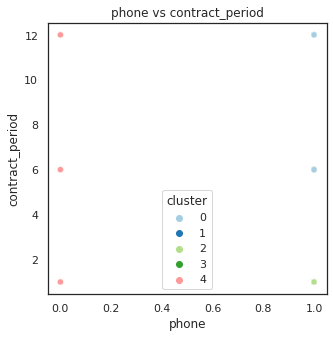

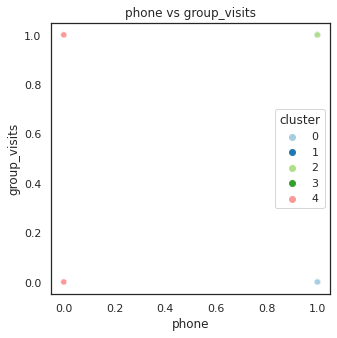

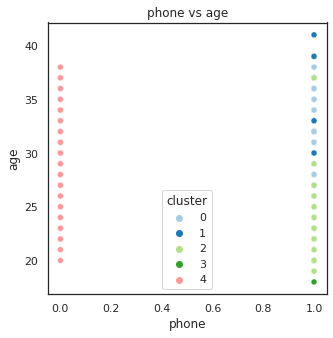

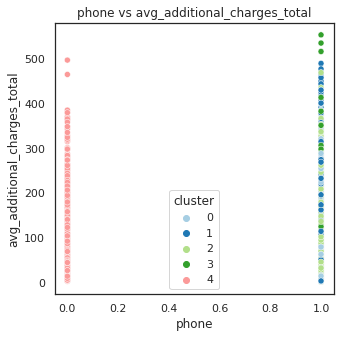

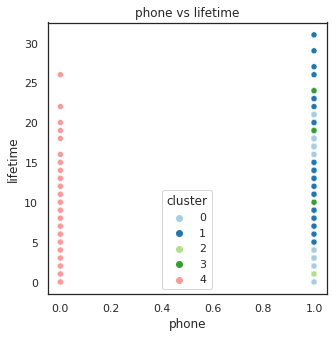

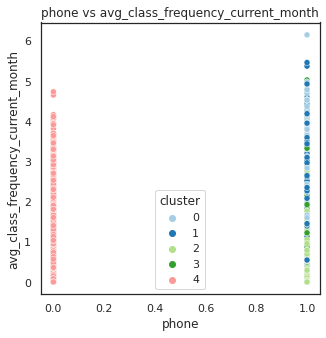

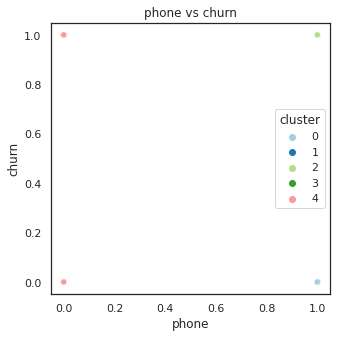

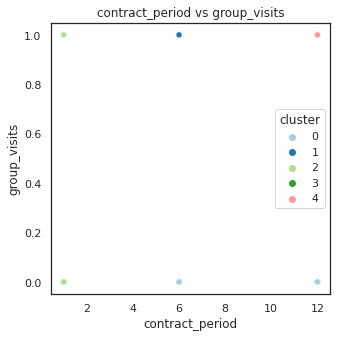

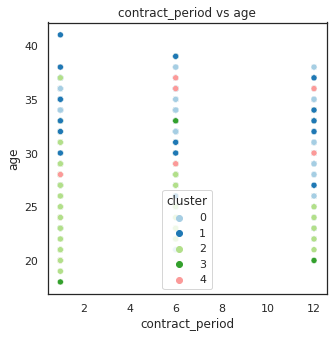

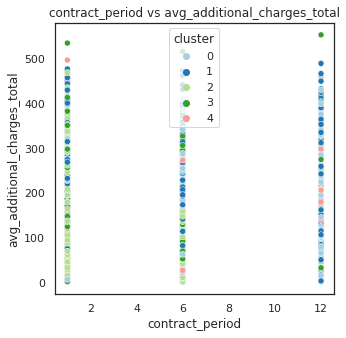

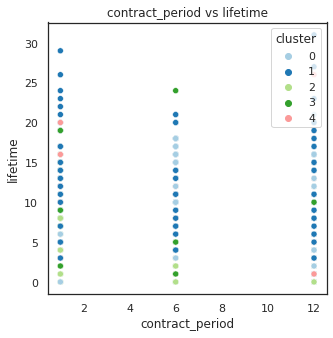

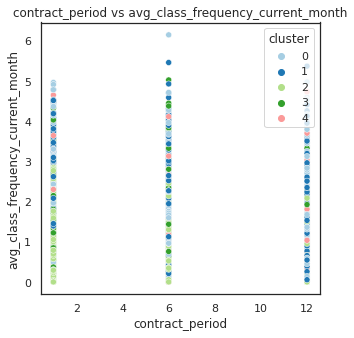

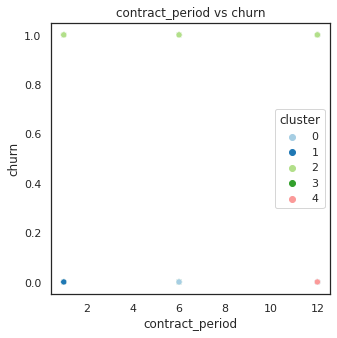

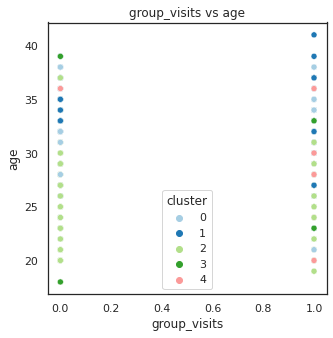

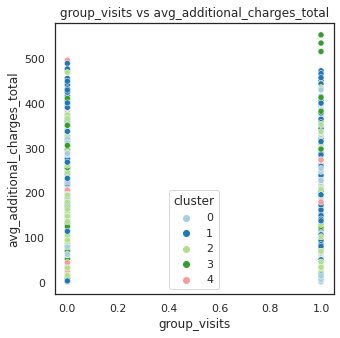

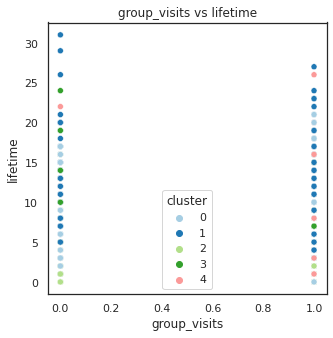

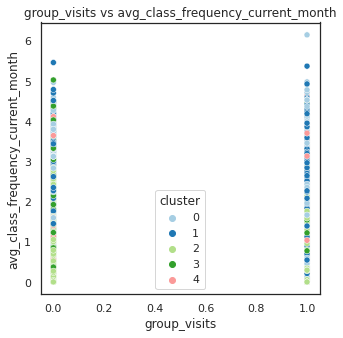

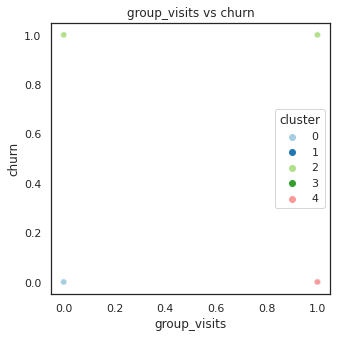

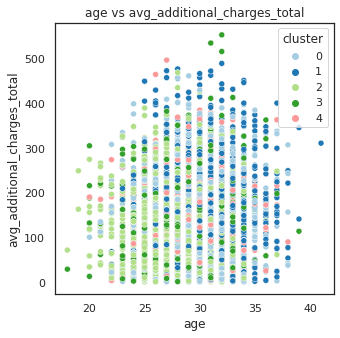

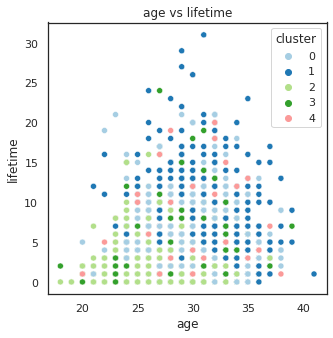

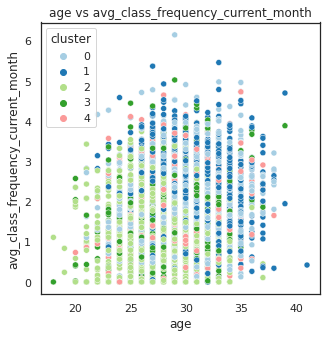

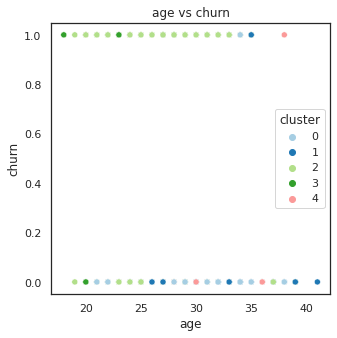

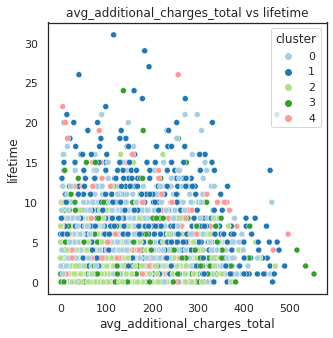

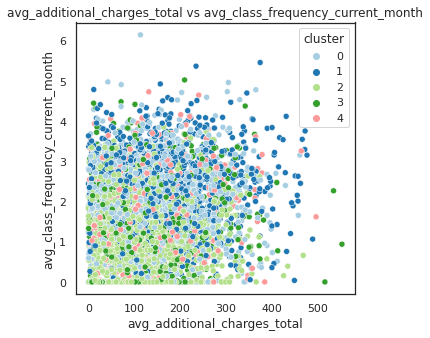

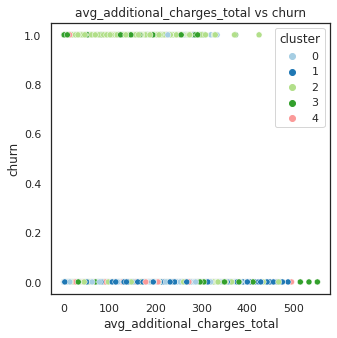

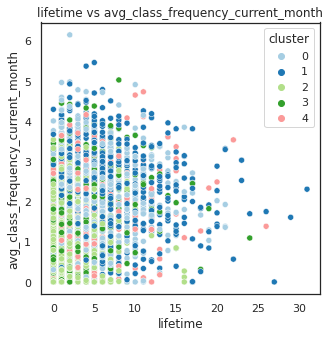

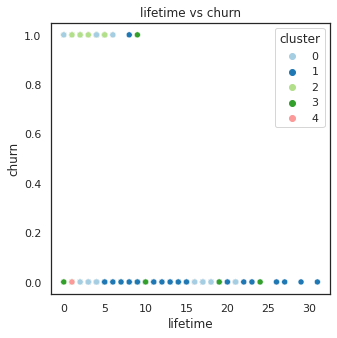

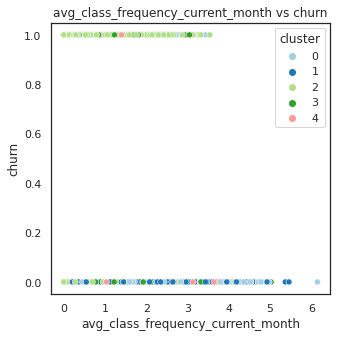

In [40]:
# отрисуем графики для попарных сочетаний признаков с разметкой по кластерам
col_pairs = list(itertools.combinations(gym_churn_clear.drop('cluster', axis=1).columns, 2))
for pair in col_pairs:
    show_clusters_on_plot(gym_churn_clear, pair[0], pair[1], 'cluster')

По оси Х на графиках сочетаний - значения одного признака, по оси Y значения второго признака, точка на графике – это какой-то один объект. Цвет определяет кластер.
Пограничными признаками для клаетров будет такая пара, на которой пересечение объектов из разных кластеров будет минимально.
Так из всех пар более выражены кластерные различия в признаках Близость работы/жилья и Выручка с дополнительных услуг. Несколько хуже, но все же видны различия по группам на графике пары признаков Близость работы/жилья - Лайфтайм.

Воспользуемся предыдущей функцией, добавим в нее разбивку по кластерам и отрисуем тот же вид диаграмм.

In [41]:
#составим функцию
def draw_plots_clusters(data_to_plot): 
    
    #переименовываем столбцы для отрисовки
    data_to_plot = data_to_plot.rename(columns={
        'gender' : 'Пол',
        'near_location' : 'Проживание в районе фитнес-центра',
        'partner' : 'Сотрудник компании-партнера',
        'promo_friends' : 'Акция "Приведи друга"',
        'phone' : 'Телефон',
        'contract_period' : 'Текущий абонемент',
        'group_visits' : 'Групповые занятия',
        'age' :  'Возраст',
        'avg_additional_charges_total' : 'Выручка от прочих услуг',
        'lifetime' : 'Лайфтайм',
        'avg_class_frequency_current_month' :  'Средняя частота посещений в неделю за месяц',
        'churn' : 'Группа оттока', 
        'cluster' : 'Кластер'
            })

    #получаем список столбцов
    columns_to_plot=data_to_plot.columns.to_list()
    
    #составяем список бинарных признаков
    fact_columns = ['Пол', 
                    'Проживание в районе фитнес-центра', 
                    'Сотрудник компании-партнера', 
                    'Акция "Приведи друга"', 
                    'Телефон',
                    'Групповые занятия',
                    'Группа оттока'
                   ] 
        
    #напишем цикл, который для каждого столбца в списке столбцов
    #будет проверять наличие столбца в списке бинарных признаков
    #в зависимости от результата сравнения будет выводить соотвествующую диаграмму
    for column in columns_to_plot:
        if column in fact_columns:
            plt.figure(figsize = (7, 5))
            sns.countplot(
                data=data_to_plot, 
                x=data_to_plot[column], 
                hue='Кластер'
            )
            plt.title('Признак "{}"'.format(column), fontsize=16)
            plt.ylabel('Количество клиентов', fontsize=14)
            plt.xlabel(column, fontsize=14)    
            plt.legend(loc ='upper right')
            plt.grid()
            plt.show()
        else:
            sns.displot(
                x=data_to_plot[column], 
                hue='Кластер',
                multiple='dodge',
                kde=True,
                data=data_to_plot,
                height=5,
                aspect=2,
                legend=False
            )
            plt.title('Признак "{}"'.format(column), fontsize=16)
            plt.ylabel('Распределение', fontsize=14)
            plt.xlabel(column, fontsize=14)
            plt.legend(labels=[0,1,2,3,4], loc ='upper right')
            plt.grid()
            plt.show()            

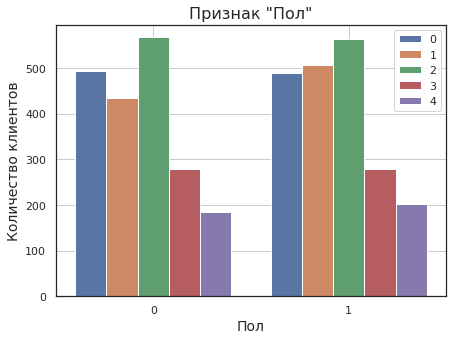

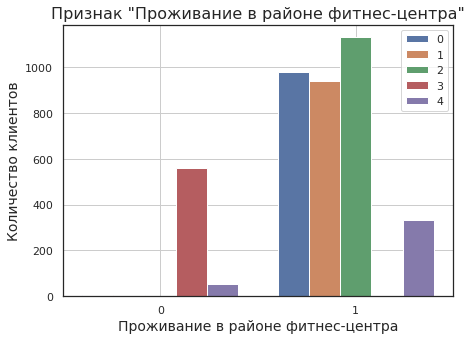

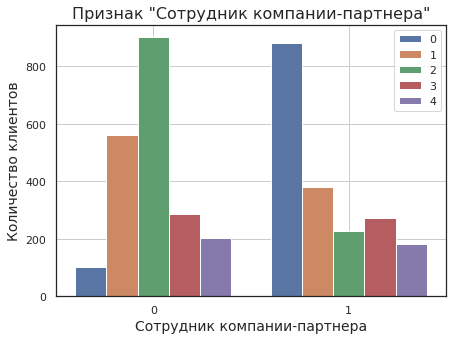

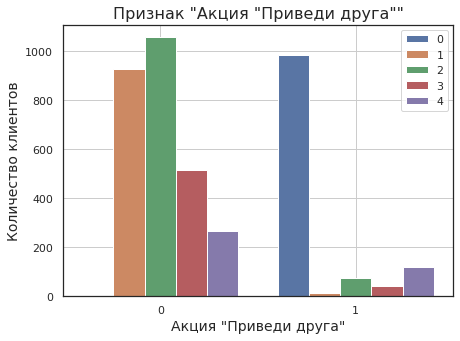

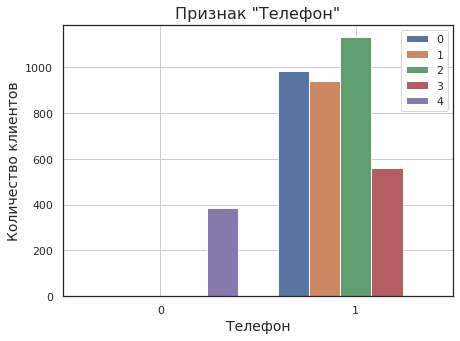

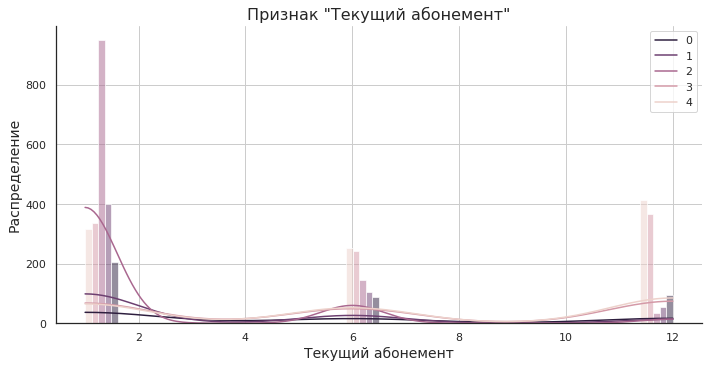

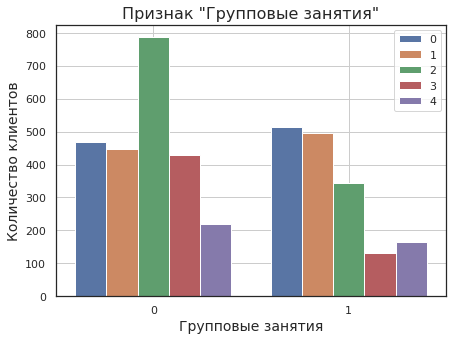

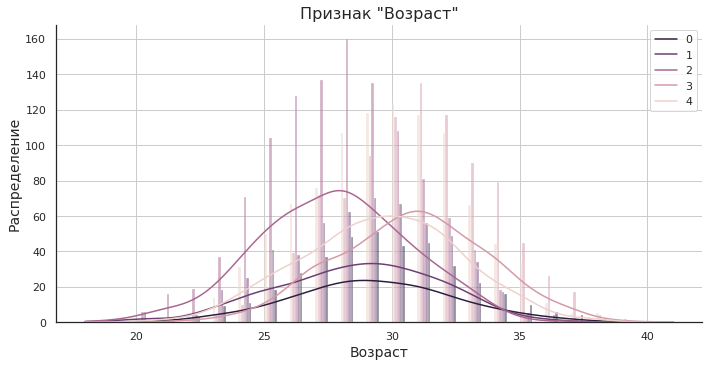

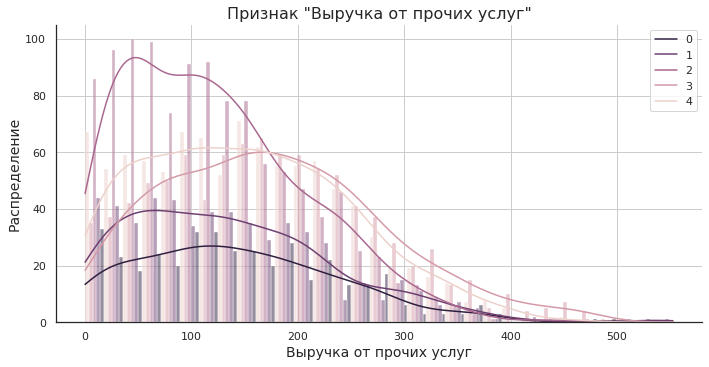

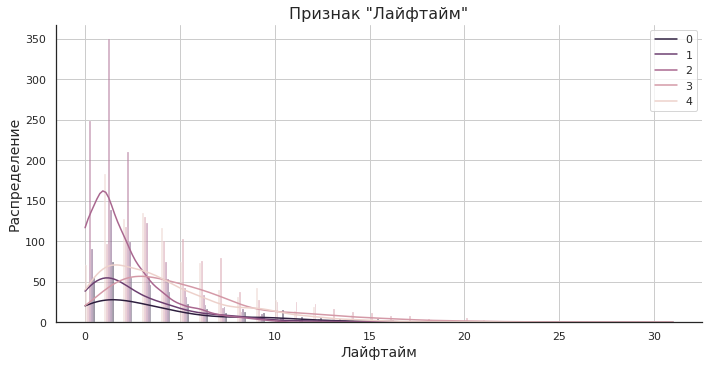

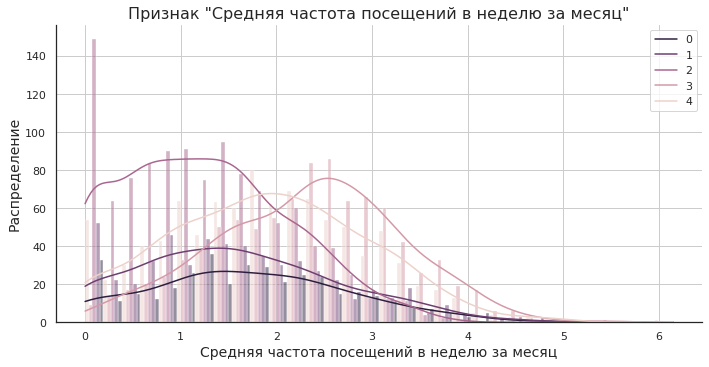

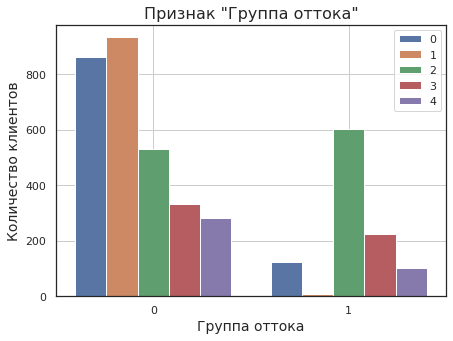

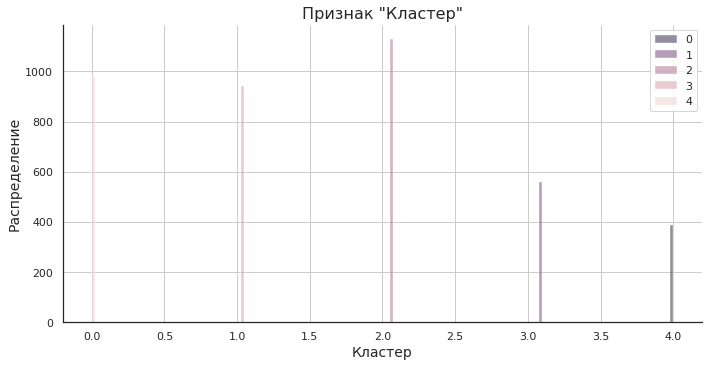

In [42]:
draw_plots_clusters(gym_churn_clear)

#### Вывод

##### Бинарные признаки
- распределение по полу примерно одинаково во всех 5 кластерах;
- признак проживания или работы рядом с фитнес-центром наиболее характерен для 0, 2 и 3 клаcтеров и наименее - для 1 кластера
- клиент является сотрудником компаний-партнеров - этот признак явно выражен в 0 кластере ,а вот клиенты из 2 и 3 кластеров практически таковыми сотрудниками не являются;
- промоакция на первую покупку абонемента успешно работает 0 кластере, а в кластерах 2 и 3 ситуация обратная;
- клиенты всех кластеров, за исключением 4, оставили свой контактный номер телефона;
- групповые занятия вотребованы у клиентов 0 и 3 кластеров, а вот клиенты из кластеров 2 и 1 практически их не покупают;
- клиенты 2 и 1 кластеров составляют самую многочисленную группу, на последнем месте по численности - 0 кластер;
- наибольшее количество оттока в 0 и 3 кластерах, наименьшее во 2 кластере

##### Количественные признаки
- Длительность текущего абонемента - клиенты из 2 кластера покупаю чаще всего абонемент на 1 месяц, клиенты 1 и 4 кластеров выбираю более долгосрочные абонементы (12 месяцев). Полугодовые абонементы во всех кластерах одинаково плохо востребованы.
- Возраст по всем кластерам примерно одинаковый от 25 до 35 лет, но можно сказать, что аудитория 1 и 4 клатеров более возрастная, а 2 - более молодая.
- Суммарная выручка от прочих услуг меньше всего у клиентов из 2 кластера, больше всего склонны тратить клиенты 0 и 3 кластеров.
- Лайфтайм (с момента первого обращения в фитнес-центр) самый короткий у 2 кластера.
- Средняя частота посещений в неделю за месяц больше всего у клиентов 1 кластера, реже всего посещают клиенты 2 кластера.


### Доля оттока по кластерам

Для каждого полученного кластера посчитаем долю оттока.

In [43]:
# вывод доли оттока клиентов для кластеров
gym_churn_clear.groupby('cluster', as_index=False)['churn'].mean().style.background_gradient('Blues', subset='churn')

,cluster,churn
0,0,0.123984
1,1,0.010616
2,2,0.531858
3,3,0.403226
4,4,0.266839


Клиенты 2 кластера наиболее склонны к оттоку - 53% (на втором месте клиенты 1 кластера - 40%). Наиболее надёжны - клиенты 3 кластера (около 1,5%).

### Вывод

По результатам кластеризации клиентов фитнес-центра:
- определены 5 кластеров, из которых 2 кластер наиболее склонен к оттоку, тогда как 3 кластер наиболее надёжный;
- 0 кластер - клиенты живут/работают рядом с фитнес-центром, участники партнерских программ и промоакций, востребованы групповые занятия и сопутствующие услуги. Ходят стабильно около 2 раз в неделю.
- 1 кластер - клиенты живут за пределами района, где расположен фитнес-центр, не интересуются промоакциями и дополнительными услугами, востребованы индивидуальные занятия, приобретают абонементы на несколько месяцев.
- 2 кластер - клиенты живут/работают рядом с фитнес-центром, длительность абонементов около 2 месяцев. Ходят заниматься индивидуально. Промоакции и дополнительные услуги интересуют мало. Самая молодая аудитория. И самый большой процент оттока.
- 3 кластер - клиенты живут/работают поблизости от фитнес-центра, активно посещают групповые занятия и заинтересованы в дополнительных услугах. Характерны самые длительные абонементы, самый длинный лайфиакйм, самая возрастная и самая лояльная группа (отток всего 1,5%).
- 4 кластер - клиенты этой группы живут/работают поблизости от фитнес-центра, скрывают свой номер телефона, средняя длительность абонемента - 5 месяцев.

## Общий вывод

<b>Первый этап</b> исследования заключался в обработке данных о посетителях фитнес-центра.
Данных достаточно для построения модели прогнозирования оттока клиентов и кластеризации клиентов по признакам.<br>
В таблице содержится 4000 наблюдений, 13 признаков, целевая переменная churn(отток).<br>
Явных выбросов, дубликатов, пропусков в данных не обнаружено.<br>
Для удобства заголовки столбцов были приведены к нижнему регистру.

На <b>втором этапе</b> был произведен исследовательский анализ данных (EDA). Изучены средние значения и стандартные отклонения признаков (в том числе и в разрезе групп). Получены следующие результаты:
- По гендерному признаку соотношение клиентов практически равное (51% мужкин, 49% женщин).
- Факт близости фитнес-центра к жилью/работе подтверждается для 85% клиентов.
- Почти половина аудитории (47%) являются сотрудниками партнерских компаний.
- Около 30% клиентов привлечены по акции "Приведи друга".
- Номер телефона оставляют почти все клиенты.
- Средняя длительность абонемента составляет 4,7 месяца. Наиболее востребованы абонементы на 1 месяц.
- Почти 40% клиентов посещают групповые занятия.
- Возрастные рамки адитории охватывают 26-30 лет.
- Средняя выручка с прочих услуг - примерно 146 у.е.
- Средняя частота посещений в неделю - 2 занятия в неделю и менее.

В прошлом месяце <b>в отток попали почти 27% клиентов</b>. Для них характерны краткосрочные абонементы, приритет индивидуальных тренировок над групповыми. Таким клиентам около 26 лет, они не участвуют в промоакциях фитнес-центра и не работают в компаниях-партнерах. В среднем, они посещают фитнес-центр 1 раз в неделю-две недели. Некоторые приобрели абонемент на месяц и ни разу не пришли.

Была построена <i>матрица корреляций</i>. По всем признакам корреляция отрицательная. Особенно сильно она выражена у следующих признаков: длительность текущего абонемента, возраст, срок до окончания текущего действующего абонемента, лайфтайм и средняя частота посещений в неделю за предыдущий месяц. Выявлены две пары признаков с мультиколлинеарностью. Была проведена очистка данных перед дальнейшем построением моделей.

На <b>третьем этапе</b> была построена модель прогнозирования оттока клиентов. Была проведена оценка работы двух алгоритмов - логистической регрессии и ансамблевой модели случайного леса. Для каждого алгоритма был проведен рассчет по 4 метркиам: accuracy, precision, recall, F1_score. <i>Модель линейной регрессии</i> показала чуть более хорошие результаты по стандартной и катомизированнной оценке метрик.
<br> На основании полученного графика определено четыре кластера в данных.

На <b>четвёртом этапе</b> на основании алгоритма K-means и стандартизированных данных были спрогнозированы 5 кластеров клиентов.

<b>Кластер 0.</b> Клиенты, которые живут/работают в непосредственной близости от фитнес-центра. Среди них самая большая доля участников партнерских программ. Обладатели самых длительных абонементов. Активно покупают сопутствующие услуги. Все записались первоначально по промо-акции. Посещают фитнес-центр около 2 раз в неделю. Процент оттока составляет 12%.

<b>Кластер 1.</b> Клиенты, которые не живут/работают в районе, где расположен фитнес-центр, не воспользовавшиеся записью по промоакции, почти не посещающие групповые занятия. В 50% случаев являются сотрудниками партнерских компаний. Среди них мало востребованы дополнительные услуги. Длительность абонемента составляет около 3 месяцев. Процент оттока составляет 40%.

<b>Кластер 2.</b> Клиенты, которые живут/работают в непосредственной близости от фитнес-центра. В 20% случаев сотрудники компаний-партнеров. Промоакция не востребована. Почти не посещают групповые занятия, дополнительные услуги покупают редко. Самая молодая аудитория - 27,5 лет. Длительность абонемента составляет 2 месяца. Самый большой процент оттока - 53%.

<b>Кластер 3.</b> Клиенты, которые живут/работают в непосредственной близости от фитнес-центра, не воспользовавшиеся записью по промоакции. Активно посещающие групповые занятия (54%). Среди них очень востребованы дополнительные услуги. Самый длительный лафйтайм. Самая возрастная группа (30 лет). Длительность абонемента составляет около полугода. Чаще всего посещают фитнес-центр (2 раза в неделю). Оттока практически нет (1%) - это самая лояльная категория клиентов.

<b>Кластер 4.</b> Клиенты, которые живут/работают примерно в районе от фитнес-центра. Не оставили свой контактный номер телефона. 47% из них являются сотрудниками компаний-партнеров, в 30% случаев использовали промоакцию при первичной записи. Средняя длительность абонемента - около 5 месяцев. Ходят на групповые занятия. Оплачивают дополнительные услуги. Процент оттока составляет 27%

### Рекомендации

1. Перпективным видится привлечение клиентов из ближайших районов.
2. Требуется поиск дополнительной мотивации для молодёжи.
3. Расширение спектра абонементов (например, на 3 месяца).
4. Поиск путей поддержки индивидуальных занятий.
5. Установление более выгодных цен на длительные абонементы.
6. Анализ транспортной доступности, достаточного количества парковочных мест - для удержания клиентов из отдаленных районов.
7. Разработка рекламных предложений на дополнительные услуги в подарок к абонементу, расширение партнерской сети.
8. Дополнительно проанализировать поведение клиентов из 2 кластера (с максимальным процентом оттока) и 3 кластера (с минимальным процентом оттока).
9. Изучить движение клиентов между кластерами для выявления условий, при которых это происходит.
10. Клиенты, не оставившие номер телефона, могут быть не в курсе специальных акций - возможно стоит подумать о новых каналах оповещения (например, через публичные группы, в которых не видно персональных данных).

